In [2]:
import numpy as np 
import pandas as pd
import random
import matplotlib.pyplot as plt 
import seaborn as sns

HELPER FUNCTIONS

In [3]:
# Make a deck
def make_decks(num_decks, card_types):
    new_deck = []
    for i in range(num_decks):
        for j in range(4):
            new_deck.extend(card_types)
    random.shuffle(new_deck)
    return new_deck

In [4]:
# This function lists out all permutations of ace values in the
# array sum_array.
# For example, if you have 2 aces, there are 4 permutations:
#     [[1,1], [1,11], [11,1], [11,11]]
# These permutations lead to 3 unique sums: [2, 12, 22]
# Of these 3, only 2 are <=21 so they are returned: [2, 12]
def get_ace_values(temp_list):
    sum_array = np.zeros((2**len(temp_list), len(temp_list)))
    # This loop gets the permutations
    for i in range(len(temp_list)):
        n = len(temp_list) - i
        half_len = int(2**n * 0.5)
        for rep in range(int(sum_array.shape[0]/half_len/2)):
            sum_array[rep*2**n : rep*2**n+half_len, i]=1
            sum_array[rep*2**n+half_len : rep*2**n+half_len*2, i]=11
    # Only return values that are valid (<=21)
    return list(set([int(s) for s in np.sum(sum_array, axis=1)\
                     if s<=21]))
# Convert num_aces, an int to a list of lists
# For example if num_aces=2, the output should be [[1,11],[1,11]]
# I require this format for the get_ace_values function
def ace_values(num_aces):
    temp_list = []
    for i in range(num_aces):
        temp_list.append([1,11])
    return get_ace_values(temp_list)

In [7]:
#Total value of hand
def total_up(hand):
    aces = 0
    total = 0

    for card in hand:
        if card != 'A':
            total += card
        else:
            aces += 1
    
    #Call function ace values to list the possible ace values for aces in hand
    ace_value_list = ace_values(aces)
    final_totals = [i + total for i in ace_value_list if i + total <= 21]

    if final_totals == []:
        return min(ace_value_list) + total
    else:
        return max(final_totals)
        

MAIN LOOP

In [15]:
stacks = 50000
players = 1
num_decks = 1

card_types = ['A',2,3,4,5,6,7,8,9,10,10,10,10]

dealer_card_feature = []
player_card_feature = []
player_results = []

for stack in range(stacks):
    blackjack = set(['A',10])
    dealer_cards = make_decks(num_decks, card_types)
    while len(dealer_cards) > 20:
        
        curr_player_results = np.zeros((1,players))
        
        dealer_hand = []
        player_hands = [[] for player in range(players)]

        # Deal FIRST card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))
        # Deal SECOND card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))

        # Dealer checks for 21
        if set(dealer_hand) == blackjack:
            for player in range(players):
                if set(player_hands[player]) != blackjack:
                    curr_player_results[0,player] = -1
                else:
                    curr_player_results[0,player] = 0
        else:
            for player in range(players):
                # Players check for 21
                if set(player_hands[player]) == blackjack:
                    curr_player_results[0,player] = 1
                else:
                    # Hit randomly, check for busts
                    while (random.random() >= 0.5) and (total_up(player_hands[player]) != 21):
                        player_hands[player].append(dealer_cards.pop(0))
                        if total_up(player_hands[player]) > 21:
                            curr_player_results[0,player] = -1
                            break
        
        # Dealer hits based on the rules
        while total_up(dealer_hand) < 17:
            dealer_hand.append(dealer_cards.pop(0))
        # Compare dealer hand to players hand but first check if dealer busted
        if total_up(dealer_hand) > 21:
            for player in range(players):
                if curr_player_results[0,player] != -1:
                    curr_player_results[0,player] = 1
        else:
            for player in range(players):
                if total_up(player_hands[player]) > total_up(dealer_hand):
                    if total_up(player_hands[player]) <= 21:
                        curr_player_results[0,player] = 1
                elif total_up(player_hands[player]) == total_up(dealer_hand):
                    curr_player_results[0,player] = 0
                else:
                    curr_player_results[0,player] = -1
        #print('player: ' + str(total_up(player_hands[player])),
        #      'dealer: ' + str(total_up(dealer_hand)),
        #      'result: ' + str(curr_player_results)
        #     )    
        
        # Track features
        dealer_card_feature.append(dealer_hand[0])
        player_card_feature.append(player_hands)
        player_results.append(list(curr_player_results[0]))

model_df = pd.DataFrame()
model_df['dealer_card'] = dealer_card_feature
model_df['player_total_initial'] = [total_up(i[0][0:2]) for i in player_card_feature]
model_df['Y'] = [i[0] for i in player_results]

lose = []
for i in model_df['Y']:
    if i == -1:
        lose.append(1)
    else:
        lose.append(0)
model_df['lose'] = lose

has_ace = []
for i in player_card_feature:
    if ('A' in i[0][0:2]):
        has_ace.append(1)
    else:
        has_ace.append(0)
model_df['has_ace'] = has_ace

dealer_card_num = []
for i in model_df['dealer_card']:
    if i=='A':
        dealer_card_num.append(11)
    else:
        dealer_card_num.append(i)
model_df['dealer_card_num'] = dealer_card_num

In [16]:
sum(pd.DataFrame(player_results)[0].value_counts())

312413

In [17]:
pd.DataFrame(player_results)[0].value_counts()

-1.0    199580
 1.0     99388
 0.0     13445
Name: 0, dtype: int64

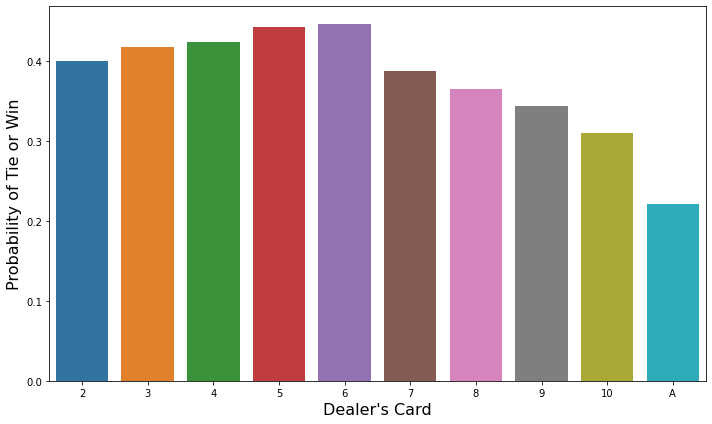

In [18]:
data = 1 - (model_df.groupby(by='dealer_card').sum()['lose']/\
            model_df.groupby(by='dealer_card').count()['lose'])

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=data.index, 
                 y=data.values)
ax.set_xlabel("Dealer's Card",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)

plt.tight_layout()
plt.savefig(fname='dealer_card_probs', dpi=150)

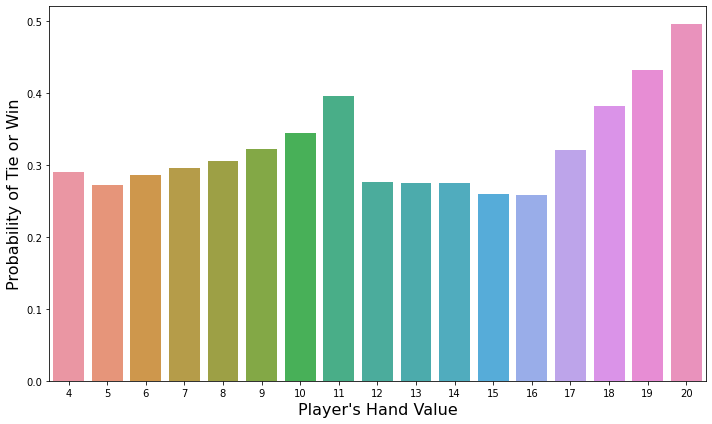

In [19]:
data = 1 - (model_df.groupby(by='player_total_initial').sum()['lose'] /\
            model_df.groupby(by='player_total_initial').count()['lose'])

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=data[:-1].index,
                 y=data[:-1].values)
ax.set_xlabel("Player's Hand Value",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)

plt.tight_layout()
plt.savefig(fname='player_hand_probs', dpi=150)

In [20]:
model_df.groupby(by='has_ace').sum()['lose'] / model_df.groupby(by='has_ace').count()['lose']

has_ace
0    0.683649
1    0.383792
Name: lose, dtype: float64

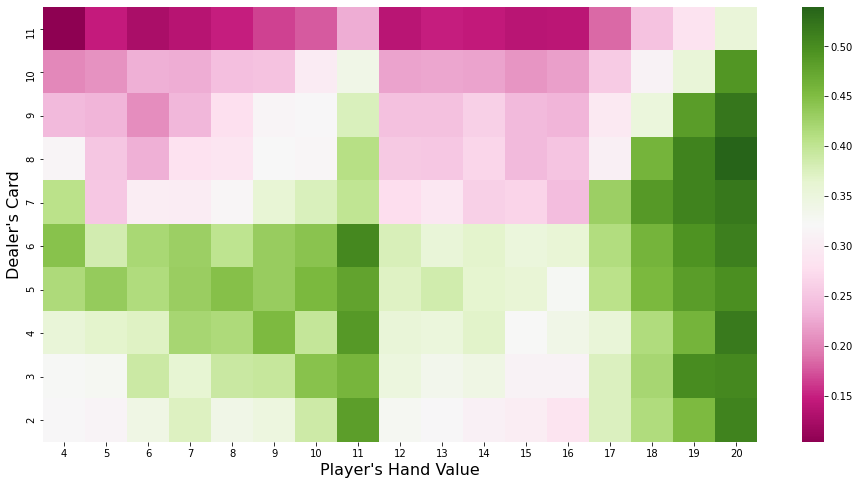

In [21]:
pivot_data = model_df[model_df['player_total_initial'] != 21]

losses_pivot = pd.pivot_table(pivot_data, values='lose', 
                              index=['dealer_card_num'],
                              columns = ['player_total_initial'],
                              aggfunc = np.sum)

games_pivot =  pd.pivot_table(pivot_data, values='lose', 
                              index=['dealer_card_num'],
                              columns = ['player_total_initial'],
                              aggfunc = 'count')

heat_data = 1 - losses_pivot.sort_index(ascending=False) / games_pivot.sort_index(ascending=False)

fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(heat_data, square=False, cmap="PiYG");

ax.set_xlabel("Player's Hand Value",fontsize=16)
ax.set_ylabel("Dealer's Card",fontsize=16)

plt.savefig(fname='heat_map_random', dpi=150)

In [22]:
stacks = 50000
players = 1
num_decks = 1

card_types = ['A',2,3,4,5,6,7,8,9,10,10,10,10]

dealer_card_feature = []
player_card_feature = []
player_results = []

for stack in range(stacks):
    blackjack = set(['A',10])
    dealer_cards = make_decks(num_decks, card_types)
    while len(dealer_cards) > 20:
        
        curr_player_results = np.zeros((1,players))
        
        dealer_hand = []
        player_hands = [[] for player in range(players)]

        # Deal FIRST card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))
        # Deal SECOND card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))

        # Dealer checks for 21
        if set(dealer_hand) == blackjack:
            for player in range(players):
                if set(player_hands[player]) != blackjack:
                    curr_player_results[0,player] = -1
                else:
                    curr_player_results[0,player] = 0
        else:
            for player in range(players):
                # Players check for 21
                if set(player_hands[player]) == blackjack:
                    curr_player_results[0,player] = 1
                else:
                    # Hit only when we know we will not bust
                    while total_up(player_hands[player]) <= 11:
                        player_hands[player].append(dealer_cards.pop(0))
                        if total_up(player_hands[player]) > 21:
                            curr_player_results[0,player] = -1
                            break
        
        # Dealer hits based on the rules
        while total_up(dealer_hand) < 17:
            dealer_hand.append(dealer_cards.pop(0))
        # Compare dealer hand to players hand but first check if dealer busted
        if total_up(dealer_hand) > 21:
            for player in range(players):
                if curr_player_results[0,player] != -1:
                    curr_player_results[0,player] = 1
        else:
            for player in range(players):
                if total_up(player_hands[player]) > total_up(dealer_hand):
                    if total_up(player_hands[player]) <= 21:
                        curr_player_results[0,player] = 1
                elif total_up(player_hands[player]) == total_up(dealer_hand):
                    curr_player_results[0,player] = 0
                else:
                    curr_player_results[0,player] = -1
        #print('player: ' + str(total_up(player_hands[player])),
        #      'dealer: ' + str(total_up(dealer_hand)),
        #      'result: ' + str(curr_player_results)
        #     )    
        
        # Track features
        dealer_card_feature.append(dealer_hand[0])
        player_card_feature.append(player_hands)
        player_results.append(list(curr_player_results[0]))

model_df_smart = pd.DataFrame()
model_df_smart['dealer_card'] = dealer_card_feature
model_df_smart['player_total_initial'] = [total_up(i[0][0:2]) for i in player_card_feature]
model_df_smart['Y'] = [i[0] for i in player_results]

lose = []
for i in model_df_smart['Y']:
    if i == -1:
        lose.append(1)
    else:
        lose.append(0)
model_df_smart['lose'] = lose

has_ace = []
for i in player_card_feature:
    if ('A' in i[0][0:2]):
        has_ace.append(1)
    else:
        has_ace.append(0)
model_df_smart['has_ace'] = has_ace

dealer_card_num = []
for i in model_df_smart['dealer_card']:
    if i=='A':
        dealer_card_num.append(11)
    else:
        dealer_card_num.append(i)
model_df_smart['dealer_card_num'] = dealer_card_num

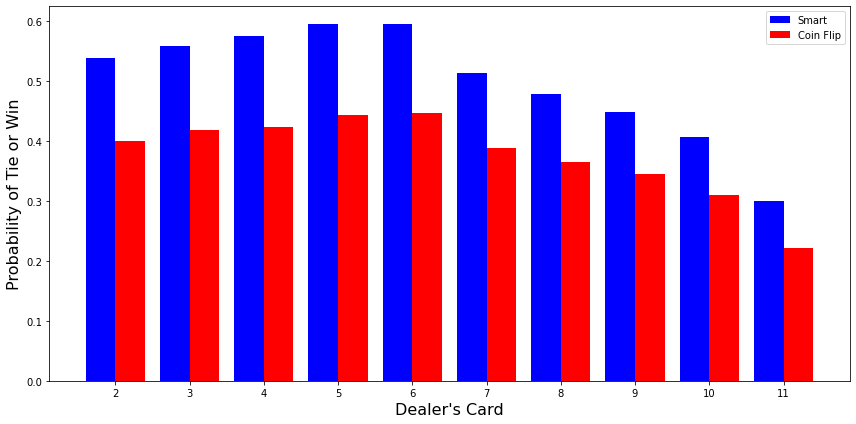

In [23]:
data_smart = 1 - (model_df_smart.groupby(by='dealer_card_num').sum()['lose'] /\
                  model_df_smart.groupby(by='dealer_card_num').count()['lose'])
data_random = 1 - (model_df.groupby(by='dealer_card_num').sum()['lose'] /\
                   model_df.groupby(by='dealer_card_num').count()['lose'])

data = pd.DataFrame()
data['smart'] = data_smart
data['random'] = data_random

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x=data.index-0.2, height=data['smart'].values, color='blue', width=0.4, label='Smart')
ax.bar(x=data.index+0.2, height=data['random'].values, color='red', width=0.4, label='Coin Flip')
ax.set_xlabel("Dealer's Card",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)
plt.xticks(np.arange(2, 12, 1.0))

plt.legend()
plt.tight_layout()
plt.savefig(fname='dealer_card_probs_smart', dpi=150)

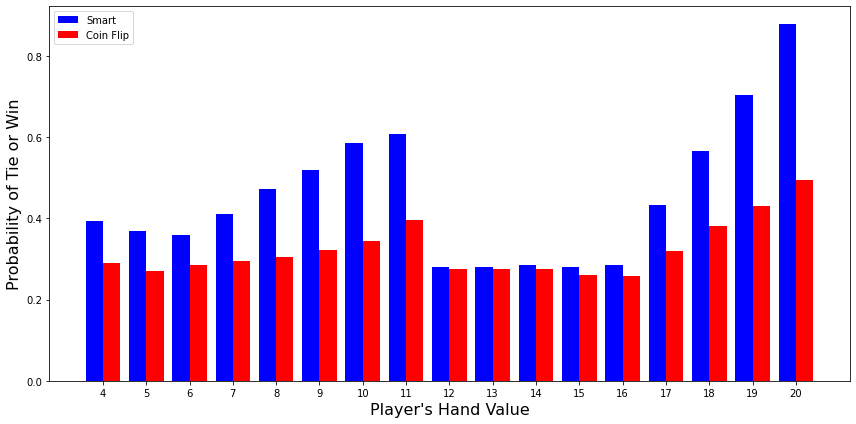

In [24]:
data_smart = 1 - (model_df_smart.groupby(by='player_total_initial').sum()['lose'] /\
                  model_df_smart.groupby(by='player_total_initial').count()['lose'])
data_random = 1 - (model_df.groupby(by='player_total_initial').sum()['lose'] /\
                   model_df.groupby(by='player_total_initial').count()['lose'])

data = pd.DataFrame()
data['smart'] = data_smart[:-1]
data['random'] = data_random[:-1]

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x=data.index-0.2, height=data['smart'].values, color='blue', width=0.4, label='Smart')
ax.bar(x=data.index+0.2, height=data['random'].values, color='red', width=0.4, label='Coin Flip')
ax.set_xlabel("Player's Hand Value",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)
plt.xticks(np.arange(4, 21, 1.0))

plt.legend()
plt.tight_layout()
plt.savefig(fname='player_hand_probs_smart', dpi=150)